In [1]:
from unet import config
from unet.model import UNet
import matplotlib.pyplot as plt
from torchvision.transforms import v2
import numpy as np
import torch
import cv2
import os


In [2]:
def prepare_plot(origImage, origMask, predMask, filename):
    # initialize our figure
    figure, ax = plt.subplots(nrows=1, ncols=3, figsize=(10, 10))
    # plot the original image, its mask, and the predicted mask
    ax[0].imshow(origImage)
    ax[1].imshow(origMask)
    ax[2].imshow(predMask)
    # set the titles of the subplots
    ax[0].set_title("Image")
    ax[1].set_title("Original Mask")
    ax[2].set_title("Predicted Mask")
    # set the layout of the figure and display it
    figure.tight_layout()
    figure.show()

In [7]:
# In the third code cell (make_predictions function):
def make_predictions(model, imagePath):
    # Define the transform pipeline
    transform = v2.Compose([
        v2.ToImage(),  # Convert NumPy HWC uint8 to Tensor HWC uint8
        v2.ToDtype(torch.float32, scale=True), # Convert to float32 and scale to [0.0, 1.0]
        v2.Resize((config.INPUT_IMAGE_HEIGHT, config.INPUT_IMAGE_WIDTH), antialias=True), # Resize CHW Tensor
    ])

    # set model to evaluation mode
    model.eval()
    # turn off gradient tracking
    with torch.no_grad():
        # load the image from disk, swap its color channels
        image = cv2.imread(imagePath)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # Keep as RGB NumPy array for transform

        # Prepare the original image for plotting (resize and scale)
        # This matches the format expected by prepare_plot in the original code
        orig = cv2.resize(image, (config.INPUT_IMAGE_WIDTH, config.INPUT_IMAGE_HEIGHT))
        orig = orig.astype("float32") / 255.0

        # find the filename and generate the path to ground truth
        # mask
        filename = os.path.basename(imagePath).split("-")[1] # Ensure this splitting logic is correct for your filenames
        groundTruthPath = os.path.join(config.MASK_DATASET_PATH, filename)
        # load the ground-truth segmentation mask in grayscale mode
        # and resize it
        gtMask = cv2.imread(groundTruthPath, 0)
        gtMask = cv2.resize(
            gtMask, (config.INPUT_IMAGE_WIDTH, config.INPUT_IMAGE_HEIGHT)
        )

        # Apply transforms, add batch dimension, and move to device
        image = transform(image) # Apply the defined transform
        image = image.unsqueeze(0) # Add batch dimension (BCHW)
        image = image.to(config.DEVICE)

        # make the prediction, pass the results through the sigmoid
        # function, and convert the result to a NumPy array
        predMask = model(image).squeeze()
        predMask = torch.sigmoid(predMask)
        predMask = predMask.cpu().numpy()
        # filter out the weak predictions and convert them to integers
        predMask = (predMask > config.THRESHOLD) * 255
        predMask = predMask.astype(np.uint8) # Convert final mask to uint8 for plot
        # prepare a plot for visualization
        prepare_plot(orig, gtMask, predMask, filename)

[INFO] loading up test image paths...
['../dataset/composite/3-11590.png' '../dataset/composite/3-10370.png'
 '../dataset/composite/1-11860.png' '../dataset/composite/3-11500.png'
 '../dataset/composite/2-11980.png' '../dataset/composite/1-11500.png'
 '../dataset/composite/1-10720.png' '../dataset/composite/2-10030.png'
 '../dataset/composite/3-10600.png' '../dataset/composite/4-10960.png']
[INFO] load up model...


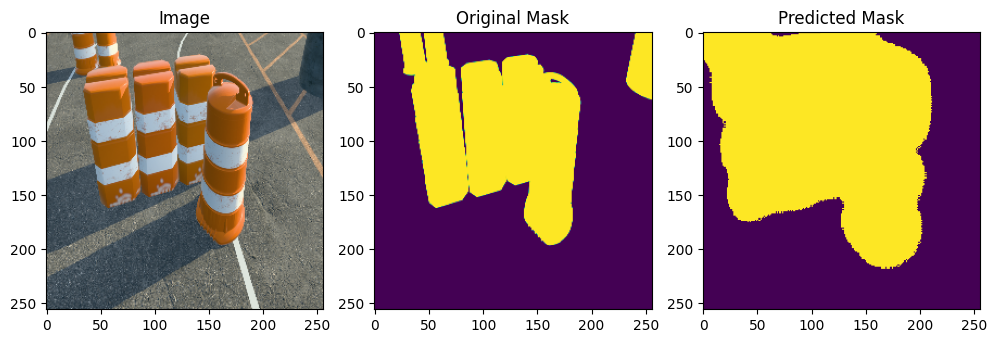

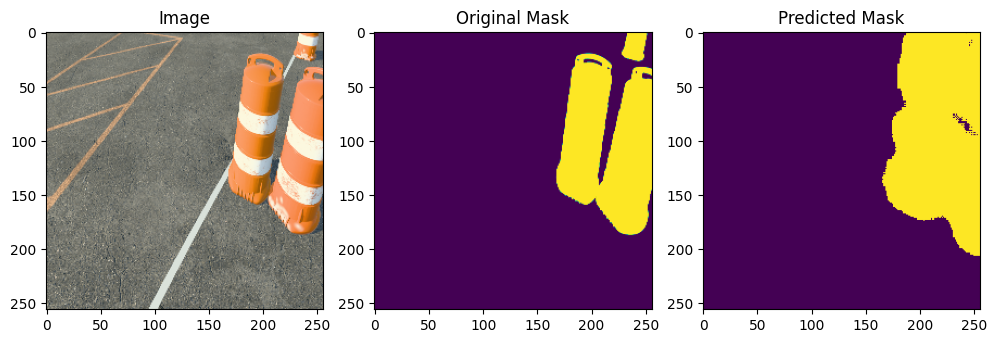

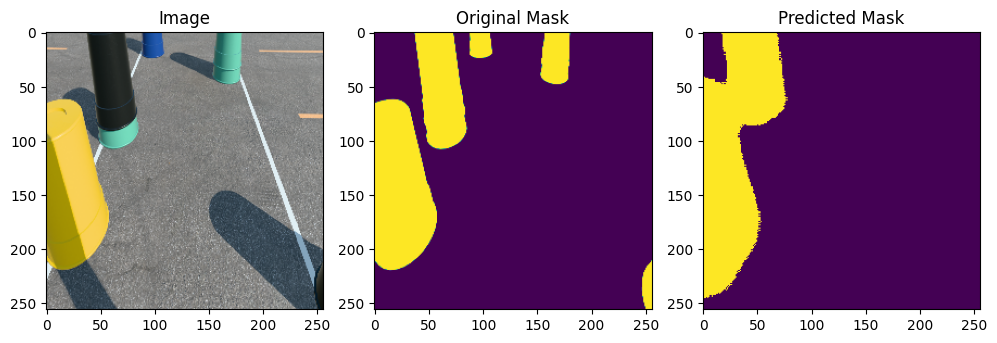

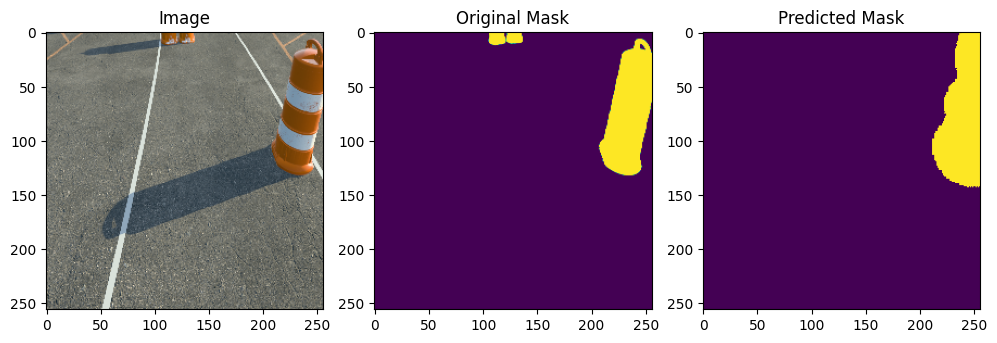

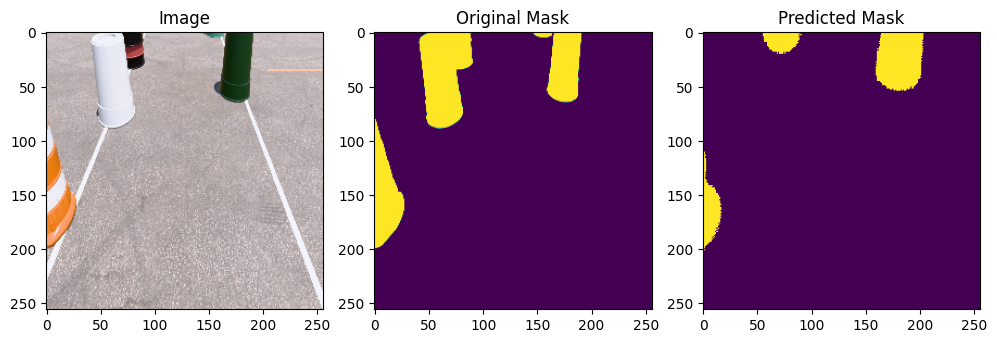

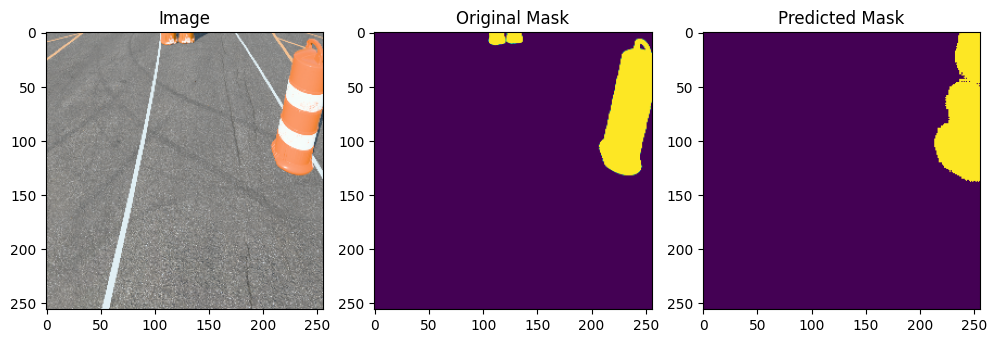

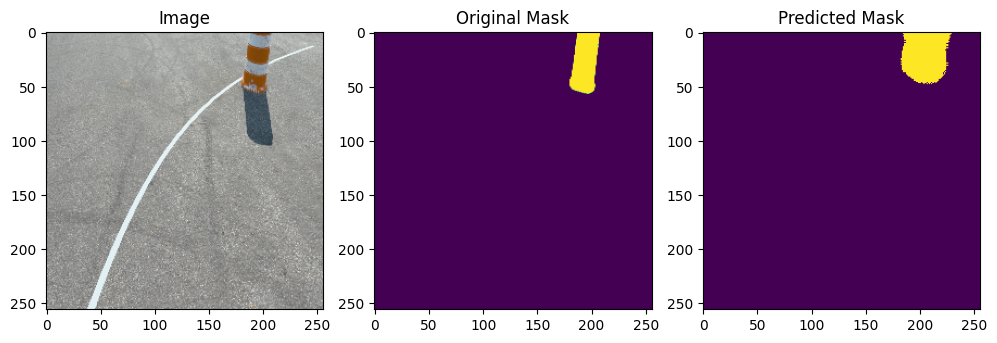

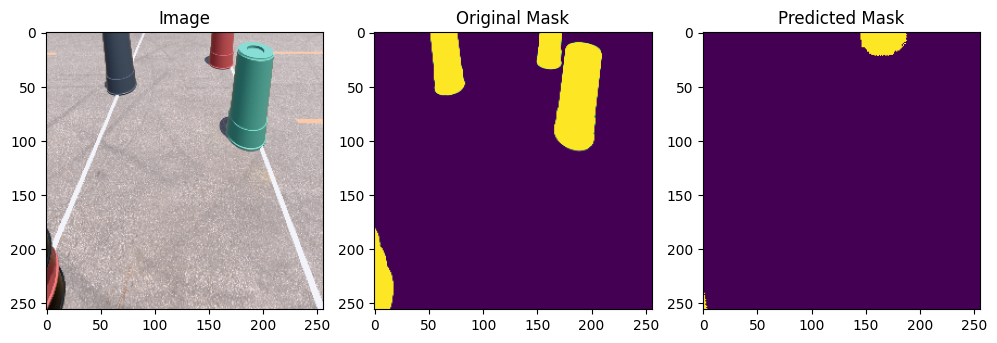

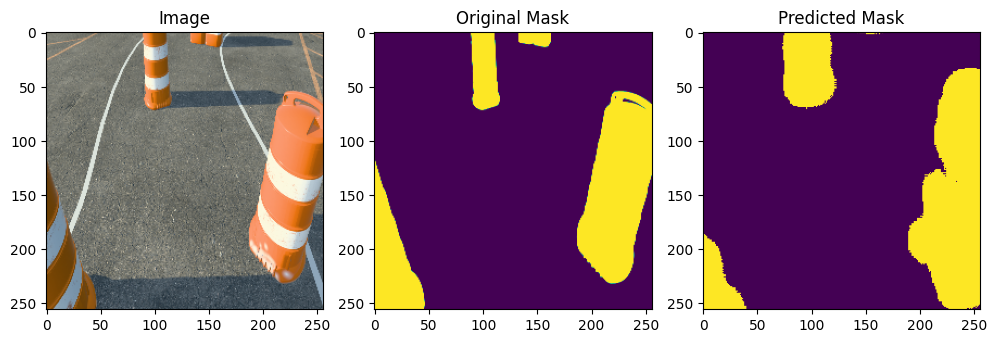

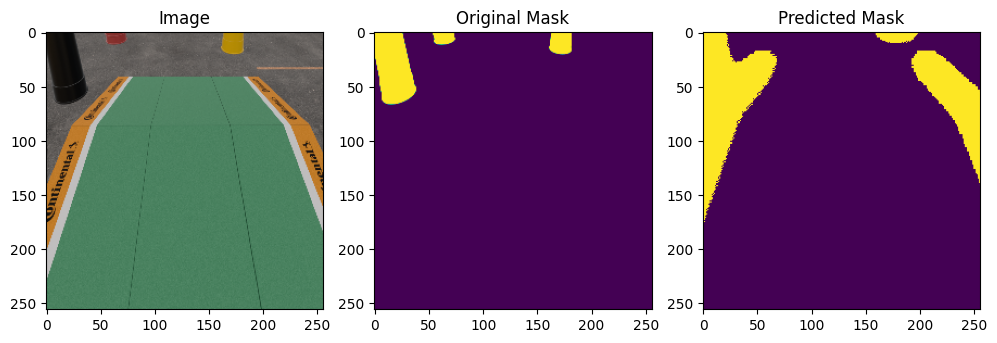

In [ ]:
# load the image paths in our testing file and randomly select 10
# image paths
print("[INFO] loading up test image paths...")
imagePaths = sorted(os.listdir((config.IMAGE_DATASET_PATH)))
imagePaths = [os.path.join(config.IMAGE_DATASET_PATH, f) for f in imagePaths]
imagePaths = np.random.choice(imagePaths, size=10)
print(imagePaths)
# load our model from disk and flash it to the current device
print("[INFO] load up model...")
model_path = None
# find latest model
for file in sorted(os.listdir(config.MODEL_PATH)):
    if file.endswith(".pth"):
        model_path = os.path.join(config.MODEL_PATH, file)

if model_path is None:
    raise ValueError("No model found in the specified directory.")

model_path = os.path.join(config.MODEL_PATH, "model_20250501_181315_11.pth")

model = UNet().to(config.DEVICE)
model.load_state_dict(torch.load(model_path))
# iterate over the randomly selected test image paths
for path in imagePaths:
    # make predictions and visualize the results
    make_predictions(model, path)